In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, XLMRobertaTokenizer, XLMRobertaModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

C:\Users\user\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Paths
base_path = 'D:/Document/BUET/Data Mining/dataset/BHM'
files_path = os.path.join(base_path, 'Files')
memes_path = os.path.join(base_path, 'Memes')

# Load datasets
train_data_task1 = pd.read_excel(os.path.join(files_path, 'train_task1.xlsx'))
valid_data_task1 = pd.read_excel(os.path.join(files_path, 'valid_task1.xlsx'))
test_data_task1 = pd.read_excel(os.path.join(files_path, 'test_task1.xlsx'))

train_data_task2 = pd.read_excel(os.path.join(files_path, 'train_task2.xlsx'))
valid_data_task2 = pd.read_excel(os.path.join(files_path, 'valid_task2.xlsx'))
test_data_task2 = pd.read_excel(os.path.join(files_path, 'test_task2.xlsx'))

In [3]:
print(train_data_task1.head())


               image_name                                           Captions  \
0     ovodro_img (79).jpg        এশিয়া কাপে অংশগ্রহন করব ।   আসছি আমি ......   
1    ovodro_img (154).jpg  দেশপ্রিয় পার্কে প্যান্ডেলে ঢোকার আগে   প্যান্ড...   
2    ovodro_img (220).jpg  আমার একটু হারামি টাইপের মেয়ে পছন্দ   আমি TIK T...   
3  nurani-memes (160).jpg  Some fresher's to the Senior Boro Vai's    একট...   
4           KAM (108).jpg  কাপলদের জন্য পহেলা বৈশাখ সিঙ্গেল দের জন্য ১লা ...   

     Labels  
0      hate  
1      hate  
2      hate  
3      hate  
4  non-hate  


In [4]:
# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [5]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


PyTorch version: 2.5.1+cu121
CUDA version: 12.1
Is CUDA available: True
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
# Dataset class
class MemeDataset(Dataset):
    def __init__(self, dataframe, image_folder, transforms=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image_name'])
        image = Image.open(image_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        text = row['Captions']
        label = row['Labels']
        return image, text, label

In [7]:
# DataLoader function
def create_dataloader(dataframe, image_folder, transforms, batch_size):
    dataset = MemeDataset(dataframe, image_folder, transforms)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 16  # Use a smaller batch size to reduce memory usage
train_loader_task1 = create_dataloader(train_data_task1, memes_path, image_transforms, batch_size)
valid_loader_task1 = create_dataloader(valid_data_task1, memes_path, image_transforms, batch_size)
test_loader_task1 = create_dataloader(test_data_task1, memes_path, image_transforms, batch_size)

train_loader_task2 = create_dataloader(train_data_task2, memes_path, image_transforms, batch_size)
valid_loader_task2 = create_dataloader(valid_data_task2, memes_path, image_transforms, batch_size)
test_loader_task2 = create_dataloader(test_data_task2, memes_path, image_transforms, batch_size)


In [8]:
# Load pre-trained models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
xlmr_model = XLMRobertaModel.from_pretrained("xlm-roberta-base").eval()

In [9]:
# Feature extraction functions
def extract_image_features(images):
    with torch.no_grad():
        return clip_model.get_image_features(images.to(torch.float16 if torch.cuda.is_available() else torch.float32))

def extract_text_features(texts):
    inputs = xlmr_tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = xlmr_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

In [11]:
# Extract and save features
def process_and_save_features(dataloader, split):
    image_features, text_features, labels = [], [], []
    for images, texts, lbls in dataloader:
        img_feats = extract_image_features(images)
        txt_feats = extract_text_features(texts)
        image_features.append(img_feats.cpu().numpy())
        text_features.append(txt_feats.cpu().numpy())
        labels.extend(lbls)
    np.save(f"{split}_image_features.npy", np.vstack(image_features))
    np.save(f"{split}_text_features.npy", np.vstack(text_features))
    np.save(f"{split}_labels.npy", np.array(labels))

process_and_save_features(train_loader_task1, "train_task1")
process_and_save_features(valid_loader_task1, "valid_task1")
process_and_save_features(test_loader_task1, "test_task1")

# process_and_save_features(train_loader_task2, "train_task2")
# process_and_save_features(valid_loader_task2, "valid_task2")
# process_and_save_features(test_loader_task2, "test_task2")


In [12]:
# Load features
train_image_features_task1 = np.load("train_task1_image_features.npy")
train_text_features_task1 = np.load("train_task1_text_features.npy")
train_labels_task1 = np.load("train_task1_labels.npy")

valid_image_features_task1 = np.load("valid_task1_image_features.npy")
valid_text_features_task1 = np.load("valid_task1_text_features.npy")
valid_labels_task1 = np.load("valid_task1_labels.npy")

# train_image_features_task2 = np.load("train_task2_image_features.npy")
# train_text_features_task2 = np.load("train_task2_text_features.npy")
# train_labels_task2 = np.load("train_task2_labels.npy")

# valid_image_features_task2 = np.load("valid_task2_image_features.npy")
# valid_text_features_task2 = np.load("valid_task2_text_features.npy")
# valid_labels_task2 = np.load("valid_task2_labels.npy")

In [13]:
# Concatenate features
def concatenate_features(image_features, text_features):
    return np.hstack((image_features, text_features))

train_features_task1 = concatenate_features(train_image_features_task1, train_text_features_task1)
valid_features_task1 = concatenate_features(valid_image_features_task1, valid_text_features_task1)

# train_features_task2 = concatenate_features(train_image_features_task2, train_text_features_task2)
# valid_features_task2 = concatenate_features(valid_image_features_task2, valid_text_features_task2)

In [14]:
# Encode labels
label_encoder_task1 = LabelEncoder()
train_labels_task1 = label_encoder_task1.fit_transform(train_labels_task1)
valid_labels_task1 = label_encoder_task1.transform(valid_labels_task1)

# label_encoder_task2 = LabelEncoder()
# train_labels_task2 = label_encoder_task2.fit_transform(train_labels_task2)
# valid_labels_task2 = label_encoder_task2.transform(valid_labels_task2)

In [15]:
# Neural Network Model
class MemeClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MemeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [16]:
# Training function with early stopping
def train_model(model, criterion, optimizer, train_features, train_labels, valid_features, valid_labels, epochs=10, patience=6):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(train_features, dtype=torch.float32)
        labels = torch.tensor(train_labels, dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(valid_features, dtype=torch.float32)
            val_labels = torch.tensor(valid_labels, dtype=torch.long)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_predictions = torch.argmax(val_outputs, dim=1)
            val_accuracy = accuracy_score(valid_labels, val_predictions.numpy())

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

In [19]:
# Task 1: Hateful vs Non-Hateful Meme Detection
input_size_task1 = train_features_task1.shape[1]
hidden_size_task1 = 128
num_classes_task1 = len(np.unique(train_labels_task1))
model_task1 = MemeClassifier(input_size_task1, hidden_size_task1, num_classes_task1)
criterion_task1 = nn.CrossEntropyLoss()
optimizer_task1 = optim.Adam(model_task1.parameters(), lr=0.001)




In [27]:
print("Training Task 1 Model")
train_model(model_task1, criterion_task1, optimizer_task1, train_features_task1, train_labels_task1, valid_features_task1, valid_labels_task1, epochs=50)

Training Task 1 Model
Epoch 1/50, Loss: 0.46201610565185547, Val Loss: 0.5107222199440002, Val Accuracy: 0.765625
Epoch 2/50, Loss: 0.4593103528022766, Val Loss: 0.5109513998031616, Val Accuracy: 0.765625
Epoch 3/50, Loss: 0.45709073543548584, Val Loss: 0.51143878698349, Val Accuracy: 0.76875
Epoch 4/50, Loss: 0.4544235169887543, Val Loss: 0.5124189257621765, Val Accuracy: 0.765625
Epoch 5/50, Loss: 0.4521782398223877, Val Loss: 0.5123592019081116, Val Accuracy: 0.7640625
Epoch 6/50, Loss: 0.449524462223053, Val Loss: 0.512694239616394, Val Accuracy: 0.7640625
Epoch 7/50, Loss: 0.4471668601036072, Val Loss: 0.5134533643722534, Val Accuracy: 0.759375
Early stopping triggered.


In [25]:
# # Task 2: Classification of Hateful Memes into TC, TI, TO, TS
# input_size_task2 = train_features_task2.shape[1]
# hidden_size_task2 = 128
# num_classes_task2 = len(np.unique(train_labels_task2))
# model_task2 = MemeClassifier(input_size_task2, hidden_size_task2, num_classes_task2)
# criterion_task2 = nn.CrossEntropyLoss()
# optimizer_task2 = optim.Adam(model_task2.parameters(), lr=0.001)

# print("Training Task 2 Model")
# train_model(model_task2, criterion_task2, optimizer_task2, train_features_task2, train_labels_task2, valid_features_task2, valid_labels_task2, epochs=50)


Training Task 2 Model
Epoch 1/50, Loss: 1.3698080778121948, Val Loss: 0.9650154709815979, Val Accuracy: 0.7966804979253111
Epoch 2/50, Loss: 0.9879273176193237, Val Loss: 0.7556958198547363, Val Accuracy: 0.7966804979253111
Epoch 3/50, Loss: 0.8089763522148132, Val Loss: 0.7138994336128235, Val Accuracy: 0.7966804979253111
Epoch 4/50, Loss: 0.7957186698913574, Val Loss: 0.7257886528968811, Val Accuracy: 0.7966804979253111
Epoch 5/50, Loss: 0.8233643770217896, Val Loss: 0.7260052561759949, Val Accuracy: 0.7966804979253111
Epoch 6/50, Loss: 0.8270745277404785, Val Loss: 0.707521378993988, Val Accuracy: 0.7966804979253111
Epoch 7/50, Loss: 0.803976833820343, Val Loss: 0.6814101338386536, Val Accuracy: 0.7966804979253111
Epoch 8/50, Loss: 0.7682797908782959, Val Loss: 0.6600459218025208, Val Accuracy: 0.7966804979253111
Epoch 9/50, Loss: 0.7358061671257019, Val Loss: 0.6540520787239075, Val Accuracy: 0.7966804979253111
Epoch 10/50, Loss: 0.7193261981010437, Val Loss: 0.6620818376541138, Va

In [23]:
# Evaluation and Metrics for Task 1
print("\nEvaluation for Task 1")
model_task1.eval()
with torch.no_grad():
    val_inputs_task1 = torch.tensor(valid_features_task1, dtype=torch.float32)
    val_outputs_task1 = model_task1(val_inputs_task1)
    val_predictions_task1 = torch.argmax(val_outputs_task1, dim=1).numpy()





Evaluation for Task 1


In [29]:
report_task1 = classification_report(valid_labels_task1, val_predictions_task1, target_names=label_encoder_task1.classes_)
print(report_task1)

              precision    recall  f1-score   support

        hate       0.74      0.59      0.66       241
    non-hate       0.78      0.87      0.82       399

    accuracy                           0.77       640
   macro avg       0.76      0.73      0.74       640
weighted avg       0.76      0.77      0.76       640



In [ ]:
# Confusion Matrix for Task 1
conf_matrix_task1 = confusion_matrix(valid_labels_task1, val_predictions_task1)
sns.heatmap(conf_matrix_task1, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder_task1.classes_, yticklabels=label_encoder_task1.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Task 1")
plt.show()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Updated training function to track metrics
def train_model_with_metrics(model, criterion, optimizer, train_features, train_labels, valid_features, valid_labels, epochs=10, patience=6):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(train_features, dtype=torch.float32)
        labels = torch.tensor(train_labels, dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        train_predictions = torch.argmax(outputs, dim=1).numpy()
        train_accuracy = accuracy_score(train_labels, train_predictions)

        # Validation
        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(valid_features, dtype=torch.float32)
            val_labels = torch.tensor(valid_labels, dtype=torch.long)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_predictions = torch.argmax(val_outputs, dim=1).numpy()
            val_accuracy = accuracy_score(valid_labels, val_predictions)

        # Log metrics
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and track metrics
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_metrics(
    model_task1, criterion_task1, optimizer_task1,
    train_features_task1, train_labels_task1,
    valid_features_task1, valid_labels_task1,
    epochs=50
)



Epoch 1/50, Loss: 0.6621708869934082, Val Loss: 0.6735872626304626, Val Accuracy: 0.6234375
Epoch 2/50, Loss: 0.6665047407150269, Val Loss: 0.6263545155525208, Val Accuracy: 0.6234375
Epoch 3/50, Loss: 0.6245432496070862, Val Loss: 0.6154268980026245, Val Accuracy: 0.71875
Epoch 4/50, Loss: 0.6198680996894836, Val Loss: 0.6025875806808472, Val Accuracy: 0.74375
Epoch 5/50, Loss: 0.6083113551139832, Val Loss: 0.5795375108718872, Val Accuracy: 0.7109375
Epoch 6/50, Loss: 0.5842360854148865, Val Loss: 0.571618914604187, Val Accuracy: 0.6765625
Epoch 7/50, Loss: 0.5763484239578247, Val Loss: 0.5620502233505249, Val Accuracy: 0.6921875
Epoch 8/50, Loss: 0.5682721734046936, Val Loss: 0.5450454354286194, Val Accuracy: 0.74375
Epoch 9/50, Loss: 0.5531910061836243, Val Loss: 0.5393944978713989, Val Accuracy: 0.7703125
Epoch 10/50, Loss: 0.5488953590393066, Val Loss: 0.5341029763221741, Val Accuracy: 0.7671875
Epoch 11/50, Loss: 0.5439317226409912, Val Loss: 0.524781346321106, Val Accuracy: 0.76

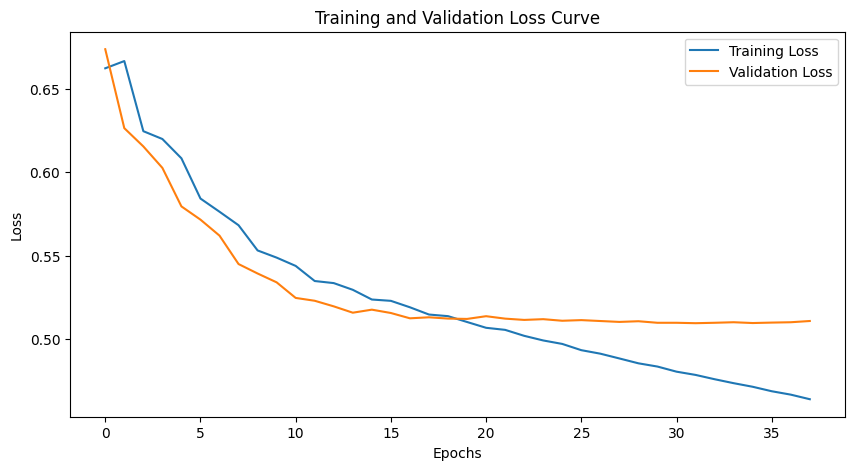

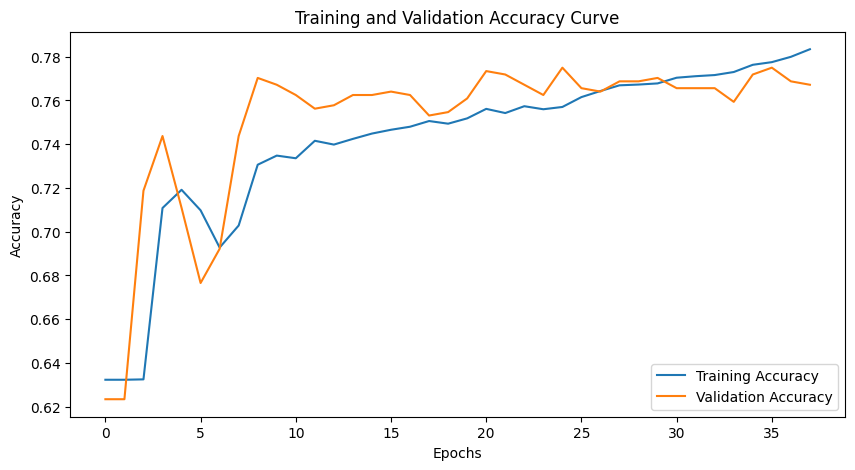

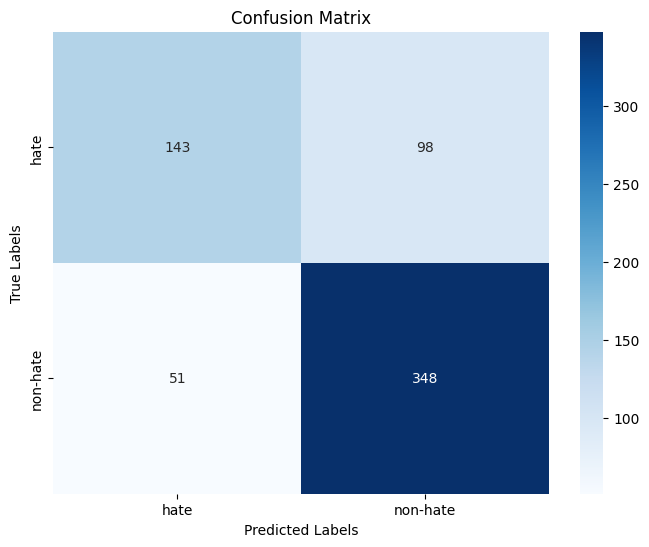

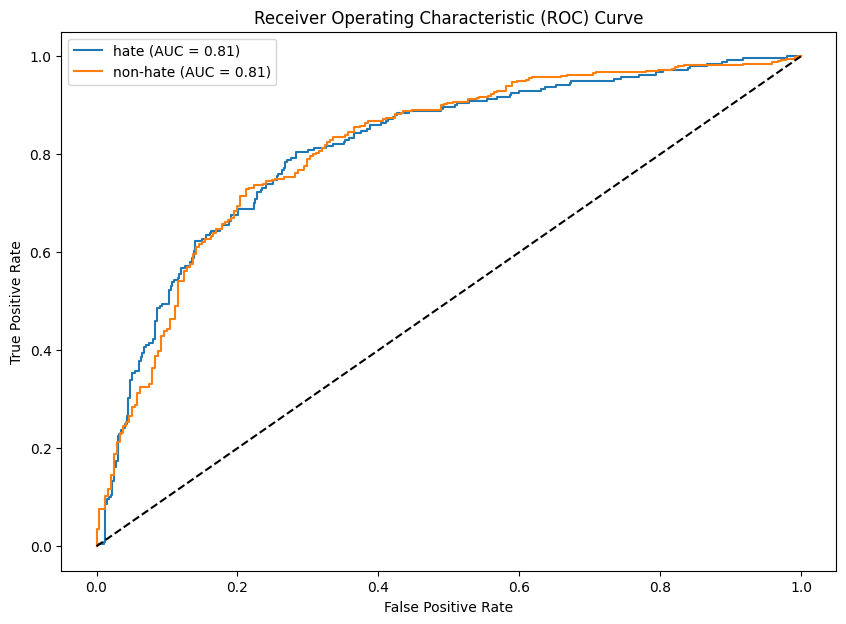

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

# Plotting Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(valid_labels_task1, val_predictions_task1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_task1.classes_, yticklabels=label_encoder_task1.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
plt.figure(figsize=(10, 7))
for i, class_label in enumerate(label_encoder_task1.classes_):
    fpr, tpr, _ = roc_curve(valid_labels_task1 == i, val_outputs_task1[:, i].numpy())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()